In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deap scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.6 MB/s eta 0:00:00


In [5]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/seg_train.zip"
extract_path = "/content/seg_train"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Jika isi zip langsung berisi folder2 kategori (buildings, forest, dll):
base_dir = extract_path
categories = os.listdir(base_dir)
print("Kategori:", categories)

Kategori: ['street', 'sea', 'mountain', 'glacier', 'buildings', 'forest']


In [6]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder

def extract_hog_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        return None
    image = cv2.resize(image, (64, 64))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
    return features

In [ ]:
X = []
y = []

for label in categories:
    folder_path = os.path.join(base_dir, label)
    image_files = os.listdir(folder_path)[:150]  # maksimal 150 gambar per kategori (biar cepat)
    print(f"Memproses {label}: {len(image_files)} gambar")

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        features = extract_hog_features(img_path)
        if features is not None:
            X.append(features)
            y.append(label)

X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)

print("Jumlah gambar berhasil diproses:", len(X))
print("Jumlah fitur per gambar:", X.shape[1])

Memproses street: 150 gambar
Memproses sea: 150 gambar
Memproses mountain: 150 gambar
Memproses glacier: 150 gambar
Memproses buildings: 150 gambar
Memproses forest: 150 gambar
Jumlah gambar berhasil diproses: 900
Jumlah fitur per gambar: 1764


In [8]:
!pip install deap

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import random
import warnings
warnings.filterwarnings("ignore")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Info fitur
num_features = X.shape[1]
print("Jumlah fitur:", num_features)

Jumlah fitur: 1764


In [10]:
from deap import base, creator, tools, algorithms

# Hapus dulu jika sudah pernah dibuat di runtime sebelumnya
from deap import creator
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

# Setup klasifikasi GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # karena kita ingin memaksimalkan akurasi
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [11]:
def evaluate(individual):
    selected = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected) == 0:
        return 0.0,  # jangan pakai tuple kosong

    X_train_sel = X_train[:, selected]
    X_test_sel = X_test[:, selected]

    model = LogisticRegression(max_iter=500)
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    acc = accuracy_score(y_test, y_pred)
    return acc,

In [12]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [13]:
# Inisialisasi populasi
pop_size = 20
generations = 10
population = toolbox.population(n=pop_size)

# Proses evolusi
final_pop, logbook = algorithms.eaSimple(population, toolbox,
                                         cxpb=0.5, mutpb=0.2,
                                         ngen=generations,
                                         verbose=True)

gen	nevals
0  	20    
1  	10    
2  	13    
3  	13    
4  	11    
5  	14    
6  	14    
7  	11    
8  	8     
9  	15    
10 	17    


In [14]:
print("\n===== GA RUN 1 | pop_size=20 | generations=10 =====")
pop_size_1 = 20
generations_1 = 10
population_1 = toolbox.population(n=pop_size_1)

final_pop_1, logbook_1 = algorithms.eaSimple(
    population_1, toolbox,
    cxpb=0.5, mutpb=0.2,
    ngen=generations_1,
    verbose=True
)

best_ind_1 = tools.selBest(final_pop_1, k=1)[0]
selected_1 = [i for i, bit in enumerate(best_ind_1) if bit == 1]

X_train_sel_1 = X_train[:, selected_1]
X_test_sel_1 = X_test[:, selected_1]

model_1 = LogisticRegression(max_iter=500)
model_1.fit(X_train_sel_1, y_train)
y_pred_1 = model_1.predict(X_test_sel_1)
acc_1 = accuracy_score(y_test, y_pred_1)

print(f"GA RUN 1 - Fitur terpilih: {len(selected_1)} - Akurasi: {acc_1:.4f}")


===== GA RUN 1 | pop_size=20 | generations=10 =====
gen	nevals
0  	20    
1  	11    
2  	14    
3  	13    
4  	14    
5  	10    
6  	8     
7  	14    
8  	13    
9  	14    
10 	9     
GA RUN 1 - Fitur terpilih: 878 - Akurasi: 0.6222


In [15]:
print("\n===== GA RUN 2 | pop_size=30 | generations=15 =====")
pop_size_2 = 30
generations_2 = 15
population_2 = toolbox.population(n=pop_size_2)

final_pop_2, logbook_2 = algorithms.eaSimple(
    population_2, toolbox,
    cxpb=0.5, mutpb=0.2,
    ngen=generations_2,
    verbose=True
)

best_ind_2 = tools.selBest(final_pop_2, k=1)[0]
selected_2 = [i for i, bit in enumerate(best_ind_2) if bit == 1]

X_train_sel_2 = X_train[:, selected_2]
X_test_sel_2 = X_test[:, selected_2]

model_2 = LogisticRegression(max_iter=500)
model_2.fit(X_train_sel_2, y_train)
y_pred_2 = model_2.predict(X_test_sel_2)
acc_2 = accuracy_score(y_test, y_pred_2)

print(f"GA RUN 2 - Fitur terpilih: {len(selected_2)} - Akurasi: {acc_2:.4f}")


===== GA RUN 2 | pop_size=30 | generations=15 =====
gen	nevals
0  	30    
1  	17    
2  	16    
3  	14    
4  	18    
5  	18    
6  	13    
7  	20    
8  	15    
9  	25    
10 	22    
11 	15    
12 	18    
13 	12    
14 	16    
15 	22    
GA RUN 2 - Fitur terpilih: 875 - Akurasi: 0.6833


In [16]:
print("\n===== GA RUN 3 | pop_size=50 | generations=20 =====")
pop_size_3 = 50
generations_3 = 20
population_3 = toolbox.population(n=pop_size_3)

final_pop_3, logbook_3 = algorithms.eaSimple(
    population_3, toolbox,
    cxpb=0.5, mutpb=0.2,
    ngen=generations_3,
    verbose=True
)

best_ind_3 = tools.selBest(final_pop_3, k=1)[0]
selected_3 = [i for i, bit in enumerate(best_ind_3) if bit == 1]

X_train_sel_3 = X_train[:, selected_3]
X_test_sel_3 = X_test[:, selected_3]

model_3 = LogisticRegression(max_iter=500)
model_3.fit(X_train_sel_3, y_train)
y_pred_3 = model_3.predict(X_test_sel_3)
acc_3 = accuracy_score(y_test, y_pred_3)

print(f"GA RUN 3 - Fitur terpilih: {len(selected_3)} - Akurasi: {acc_3:.4f}")


===== GA RUN 3 | pop_size=50 | generations=20 =====
gen	nevals
0  	50    
1  	34    
2  	31    
3  	29    
4  	32    
5  	30    
6  	22    
7  	39    
8  	27    
9  	31    
10 	28    
11 	31    
12 	37    
13 	30    
14 	26    
15 	32    
16 	31    
17 	35    
18 	27    
19 	31    
20 	36    
GA RUN 3 - Fitur terpilih: 864 - Akurasi: 0.6722


In [17]:
print("\n==== Ringkasan Hasil ====")
print(f"Run 1 | Pop=20 | Gen=10  -> Akurasi: {acc_1:.4f} | Fitur: {len(selected_1)}")
print(f"Run 2 | Pop=30 | Gen=15  -> Akurasi: {acc_2:.4f} | Fitur: {len(selected_2)}")
print(f"Run 3 | Pop=50 | Gen=20  -> Akurasi: {acc_3:.4f} | Fitur: {len(selected_3)}")


==== Ringkasan Hasil ====
Run 1 | Pop=20 | Gen=10  -> Akurasi: 0.6222 | Fitur: 878
Run 2 | Pop=30 | Gen=15  -> Akurasi: 0.6833 | Fitur: 875
Run 3 | Pop=50 | Gen=20  -> Akurasi: 0.6722 | Fitur: 864


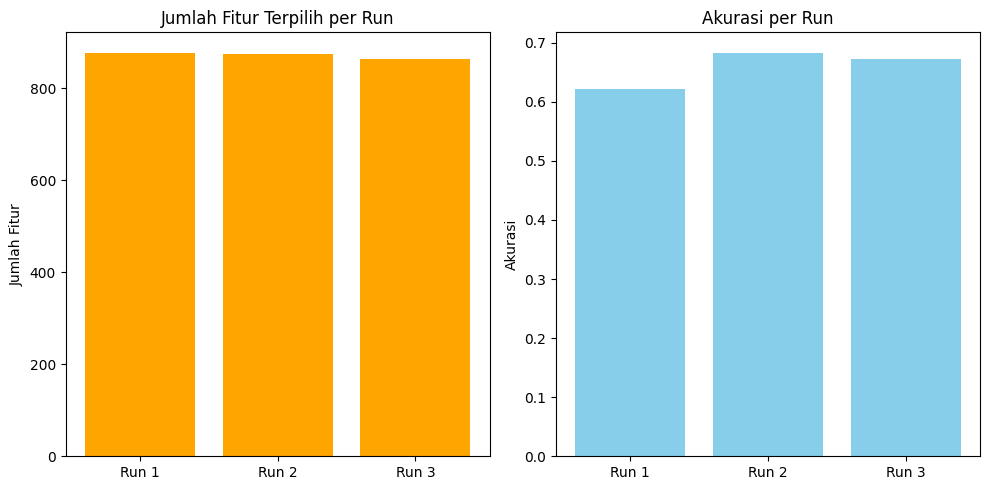

In [35]:
# Plot jumlah fitur vs akurasi
plt.figure(figsize=(10, 5))

# Subplot 1 - Jumlah fitur terpilih
plt.subplot(1, 2, 1)
plt.bar(df_summary["Run"], df_summary["Jumlah Fitur Terpilih"], color='orange')
plt.title("Jumlah Fitur Terpilih per Run")
plt.ylabel("Jumlah Fitur")

# Subplot 2 - Akurasi
plt.subplot(1, 2, 2)
plt.bar(df_summary["Run"], df_summary["Akurasi"], color='skyblue')
plt.title("Akurasi per Run")
plt.ylabel("Akurasi")

plt.tight_layout()
plt.show()

In [37]:
best_run = 3
best_accuracy = acc_3
best_features = selected_3
print(f"Run terbaik adalah Run {best_run} dengan akurasi {best_accuracy:.4f} dan {len(best_features)} fitur terpilih.")

Run terbaik adalah Run 3 dengan akurasi 0.6722 dan 864 fitur terpilih.


<Figure size 800x600 with 0 Axes>

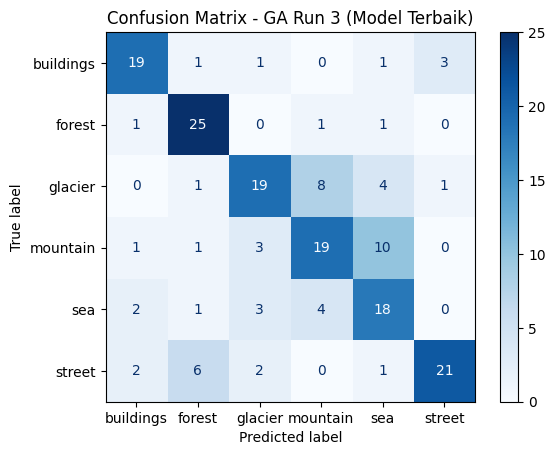

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix untuk prediksi Run 3
cm = confusion_matrix(y_test, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GA Run 3 (Model Terbaik)")
plt.show()

In [21]:
from deap import tools

# Definisikan statistik agar logbook terisi
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

In [25]:
final_pop_1, logbook_1 = algorithms.eaSimple(
    population_1, toolbox,
    cxpb=0.5, mutpb=0.2,
    ngen=generations_1,
    stats=stats,          # ← penting
    verbose=True
)

gen	nevals	avg   	max     	min     
0  	0     	0.6075	0.622222	0.561111
1  	13    	0.618333	0.633333	0.572222
2  	9     	0.621667	0.633333	0.594444
3  	10    	0.625278	0.633333	0.611111
4  	16    	0.620556	0.633333	0.583333
5  	9     	0.6275  	0.633333	0.6     
6  	12    	0.624722	0.633333	0.594444
7  	14    	0.624722	0.633333	0.583333
8  	12    	0.6325  	0.633333	0.622222
9  	13    	0.626111	0.633333	0.588889
10 	14    	0.630833	0.633333	0.605556


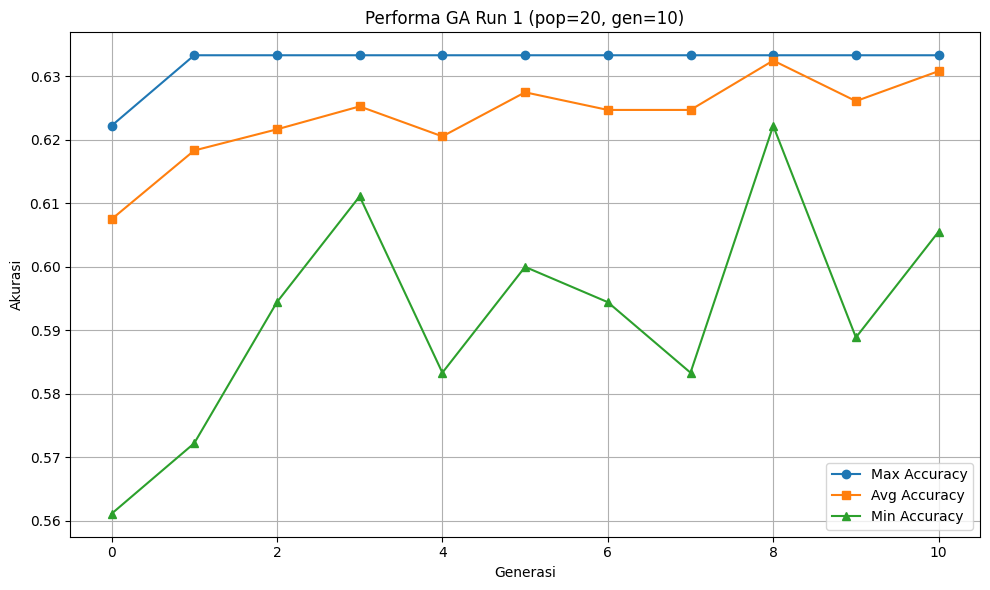

In [26]:
import matplotlib.pyplot as plt

# Pastikan logbook terisi
if len(logbook_1) > 0:
    gen_1 = logbook_1.select("gen")
    max_fit_1 = logbook_1.select("max")
    avg_fit_1 = logbook_1.select("avg")
    min_fit_1 = logbook_1.select("min")

    plt.figure(figsize=(10, 6))
    plt.plot(gen_1, max_fit_1, marker='o', label='Max Accuracy')
    plt.plot(gen_1, avg_fit_1, marker='s', label='Avg Accuracy')
    plt.plot(gen_1, min_fit_1, marker='^', label='Min Accuracy')

    plt.xlabel("Generasi")
    plt.ylabel("Akurasi")
    plt.title("Performa GA Run 1 (pop=20, gen=10)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Logbook kosong. Pastikan stats disertakan dalam eaSimple().")

In [28]:
from deap import tools

# Definisikan statistik agar logbook terisi
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

In [29]:
final_pop_2, logbook_2 = algorithms.eaSimple(
    population_2, toolbox,
    cxpb=0.5, mutpb=0.2,
    ngen=generations_2,
    stats=stats,          # ← penting agar logbook_2 tidak kosong
    verbose=True
)

gen	nevals	avg     	max     	min     
0  	0     	0.651296	0.683333	0.611111
1  	12    	0.660741	0.683333	0.633333
2  	22    	0.664259	0.688889	0.633333
3  	18    	0.66537 	0.688889	0.633333
4  	14    	0.673704	0.688889	0.616667
5  	17    	0.669074	0.688889	0.622222
6  	18    	0.677037	0.688889	0.644444
7  	15    	0.676111	0.688889	0.611111
8  	13    	0.679444	0.688889	0.622222
9  	20    	0.680556	0.688889	0.65    
10 	9     	0.68    	0.688889	0.627778
11 	21    	0.680185	0.688889	0.644444
12 	16    	0.673519	0.688889	0.616667
13 	23    	0.672778	0.688889	0.633333
14 	22    	0.678148	0.688889	0.644444
15 	21    	0.676111	0.688889	0.622222


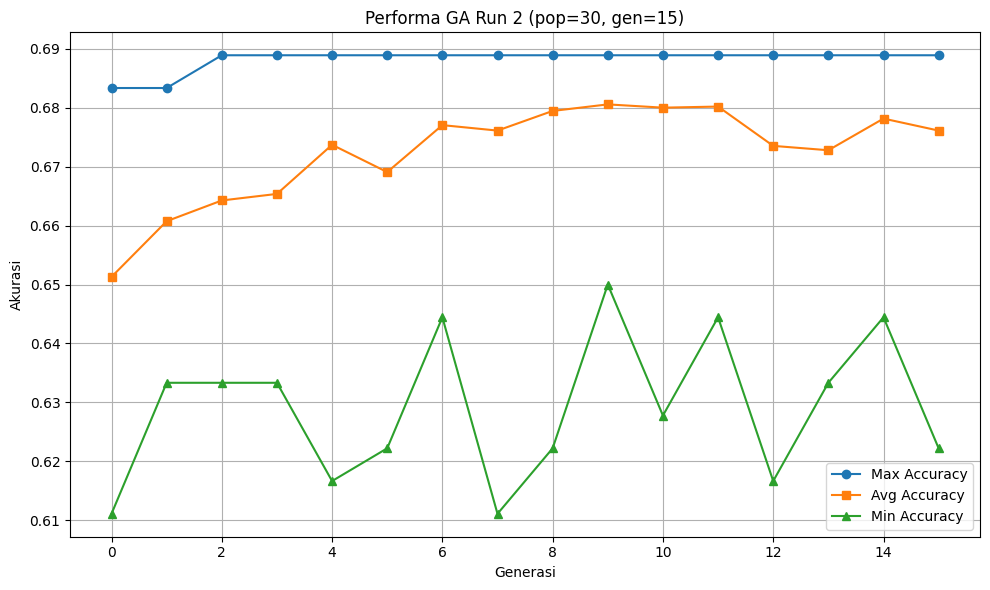

In [30]:
# Visualisasi logbook_2 (Run 2)
if len(logbook_2) > 0:
    gen_2 = logbook_2.select("gen")
    max_fit_2 = logbook_2.select("max")
    avg_fit_2 = logbook_2.select("avg")
    min_fit_2 = logbook_2.select("min")

    plt.figure(figsize=(10, 6))
    plt.plot(gen_2, max_fit_2, marker='o', label='Max Accuracy')
    plt.plot(gen_2, avg_fit_2, marker='s', label='Avg Accuracy')
    plt.plot(gen_2, min_fit_2, marker='^', label='Min Accuracy')

    plt.xlabel("Generasi")
    plt.ylabel("Akurasi")
    plt.title("Performa GA Run 2 (pop=30, gen=15)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Logbook Run 2 kosong. Pastikan stats ditambahkan saat menjalankan eaSimple.")

In [31]:
final_pop_3, logbook_3 = algorithms.eaSimple(
    population_3, toolbox,
    cxpb=0.5, mutpb=0.2,
    ngen=generations_3,
    stats=stats,          # ← agar logbook_3 bisa diplot
    verbose=True
)

gen	nevals	avg     	max     	min     
0  	0     	0.656111	0.672222	0.605556
1  	30    	0.660778	0.672222	0.6     
2  	38    	0.663111	0.672222	0.627778
3  	23    	0.665667	0.672222	0.627778
4  	20    	0.669333	0.672222	0.633333
5  	31    	0.666889	0.672222	0.638889
6  	34    	0.665333	0.683333	0.622222
7  	39    	0.665889	0.683333	0.633333
8  	36    	0.667333	0.683333	0.616667
9  	29    	0.668667	0.683333	0.616667
10 	33    	0.669778	0.683333	0.633333
11 	38    	0.668444	0.683333	0.627778
12 	28    	0.669667	0.688889	0.627778
13 	35    	0.674   	0.688889	0.638889
14 	34    	0.675111	0.688889	0.638889
15 	32    	0.679222	0.688889	0.622222
16 	31    	0.681667	0.688889	0.633333
17 	24    	0.683   	0.688889	0.633333
18 	30    	0.678222	0.688889	0.627778
19 	28    	0.684222	0.688889	0.65    
20 	32    	0.681222	0.688889	0.622222


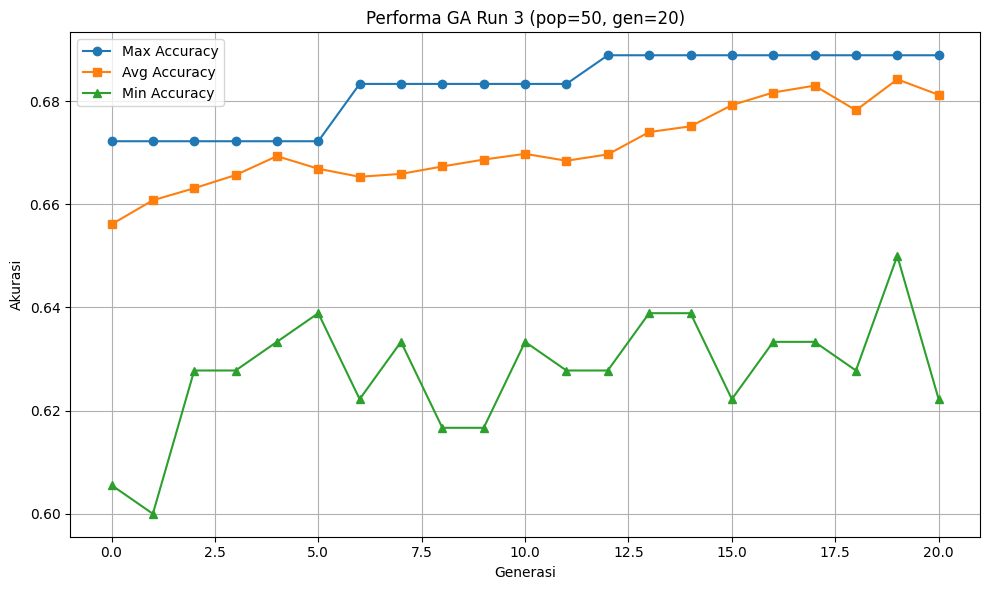

In [32]:
# Visualisasi logbook_3 (Run 3)
if len(logbook_3) > 0:
    gen_3 = logbook_3.select("gen")
    max_fit_3 = logbook_3.select("max")
    avg_fit_3 = logbook_3.select("avg")
    min_fit_3 = logbook_3.select("min")

    plt.figure(figsize=(10, 6))
    plt.plot(gen_3, max_fit_3, marker='o', label='Max Accuracy')
    plt.plot(gen_3, avg_fit_3, marker='s', label='Avg Accuracy')
    plt.plot(gen_3, min_fit_3, marker='^', label='Min Accuracy')

    plt.xlabel("Generasi")
    plt.ylabel("Akurasi")
    plt.title("Performa GA Run 3 (pop=50, gen=20)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Logbook Run 3 kosong. Pastikan stats ditambahkan saat menjalankan eaSimple.")


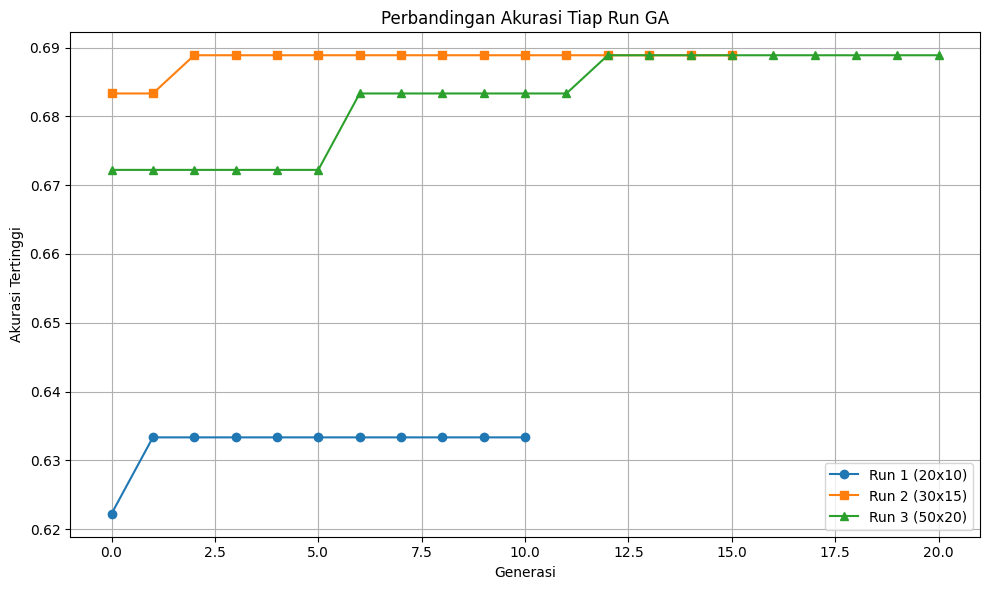

In [33]:
gen_1 = logbook_1.select("gen")
fit_1 = logbook_1.select("max")
gen_2 = logbook_2.select("gen")
fit_2 = logbook_2.select("max")
gen_3 = logbook_3.select("gen")
fit_3 = logbook_3.select("max")

plt.figure(figsize=(10, 6))
plt.plot(gen_1, fit_1, label="Run 1 (20x10)", marker='o')
plt.plot(gen_2, fit_2, label="Run 2 (30x15)", marker='s')
plt.plot(gen_3, fit_3, label="Run 3 (50x20)", marker='^')

plt.xlabel("Generasi")
plt.ylabel("Akurasi Tertinggi")
plt.title("Perbandingan Akurasi Tiap Run GA")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

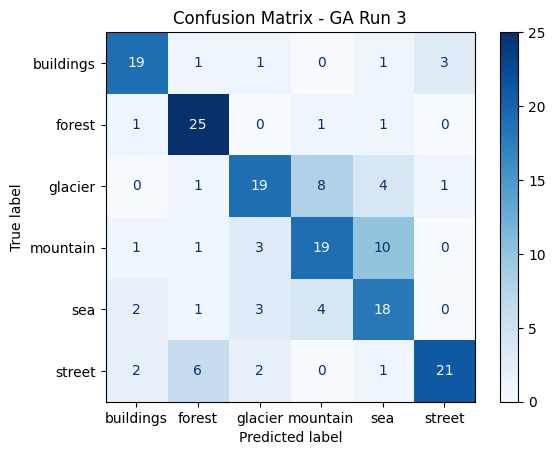

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - GA Run 3")
plt.show()